In [1]:
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor


In [2]:
# Filsti til vores datasæt
DATA_PATH = "data/vehicles.csv"
RANDOM_STATE = 7

In [3]:
# Indlæs data
def load_data():
    df = pd.read_csv(DATA_PATH)
    return df

In [4]:
# Rensning af vores data
def clean_data(df):
    df_c1 = df.copy()

    drop_cols = ['url', 'region', 'region_url', 'image_url', 'county',
                 'state', 'posting_date', 'VIN', 'description', 'lat', 'long']
    df_c1 = df_c1.drop(columns=drop_cols, errors='ignore')

    top_models = df_c1['model'].value_counts().nlargest(50).index
    df_c1['model'] = df_c1['model'].apply(lambda x: x if x in top_models else 'other')
    df_c1 = df_c1.dropna(subset=['model'])
    df_c1['odometer'] = df_c1['odometer'].fillna(df_c1['odometer'].median())


    df_c1['type'] = df_c1['type'].fillna('unknown')
    df_c1['title_status'] = df_c1['title_status'].fillna(df_c1['title_status'].mode()[0])
    df_c1['condition'] = df_c1['condition'].fillna('unknown')
    df_c1['drive'] = df_c1['drive'].fillna(df_c1['drive'].mode()[0])
    df_c1['fuel'] = df_c1['fuel'].fillna('unknown')
    df_c1['transmission'] = df_c1['transmission'].fillna('unknown')
    df_c1['size'] = df_c1['size'].fillna('unknown')
    df_c1['cylinders'] = df_c1['cylinders'].fillna('unknown')
    df_c1['paint_color'] = df_c1['paint_color'].fillna('unknown')

    df_c1 = df_c1[df_c1['price'] > 0]
    df_c1 = df_c1.dropna(subset=['price', 'year', 'manufacturer'])

    return df_c1



In [5]:
def encode_and_split(df):
    df_encoded = pd.get_dummies(df,
        columns=['manufacturer', 'model', 'condition', 'fuel', 'title_status', 
                 'transmission', 'drive', 'type', 'paint_color', 'cylinders', 'size'],
        drop_first=True)

    df_encoded['log_price'] = np.log(df_encoded['price'])

    X = df_encoded.drop(columns=['price', 'log_price'], errors='ignore')
    y = df_encoded['log_price']

    X = X.fillna(0)

    return train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)


In [6]:
# Evaluering
def evaluate_regression_model(y_true, y_pred, model_name="Model", save_path=None):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    result = {
        'Model': model_name,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    }

    print(f"{model_name} Performance:")
    print(f"MAE:  {mae:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"R^2:  {r2:.3f}\n")

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        with open(save_path, 'w') as f:
            json.dump(result, f, indent=4)

    return result


In [7]:
# Random Forest model
def plot_feature_importance(model, feature_names, top_n=10):
    importances = model.feature_importances_
    indices = np.argsort(importances)[-top_n:]

    plt.figure(figsize=(10, 6))
    plt.title("Top fremtidige Importances")
    plt.barh(range(top_n), importances[indices], align='center')
    plt.yticks(range(top_n), [feature_names[i] for i in indices])
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

def train_random_forest(X_train, y_train, X_test, y_test, feature_names=None, show_feature_importance=False):
    model = RandomForestRegressor(
        n_estimators=200,
        max_depth=15,
        oob_score=True,
        bootstrap=True,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    evaluate_regression_model(y_test, y_pred, 
                              model_name="Random Forest Regression",
                              save_path="results/random_forest_results.json")

    if hasattr(model, "oob_score_"):
        print(f"OOB Score: {model.oob_score_:.4f}")

    if show_feature_importance and feature_names is not None:
        plot_feature_importance(model, feature_names)

    return model




In [8]:
# Gradient Boosting model
def train_gradient_boosting(X_train, y_train, X_test, y_test):
    model = HistGradientBoostingRegressor(
        max_iter=100,
        max_depth=4,
        learning_rate=0.1,
        early_stopping=True,
        n_iter_no_change=10,
        max_bins=255,
        random_state=RANDOM_STATE
    )
    
    model_name = "HistGradientBoosting"
    result_file = "results/gradient_boosting_results.json"

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    evaluate_regression_model(y_test, y_pred, model_name=model_name, save_path=result_file)

    return model



Træner Random Forest...
Random Forest Regression Performance:
MAE:  0.384
RMSE: 0.795
R^2:  0.594

OOB Score: 0.6016


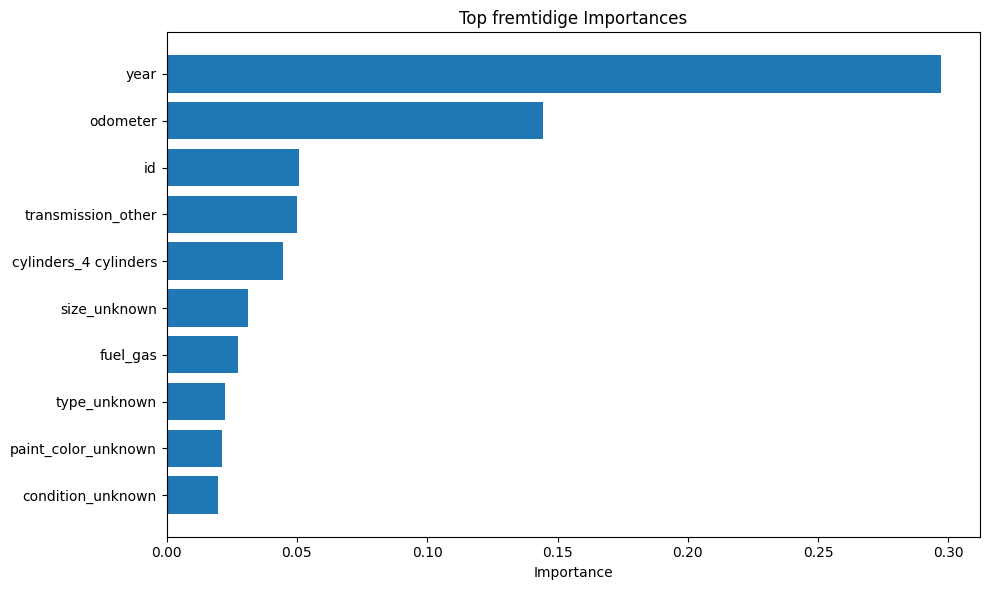

Træner Gradient Boosting...
HistGradientBoosting Performance:
MAE:  0.460
RMSE: 0.950
R^2:  0.420



In [9]:
def main():
    df = load_data()
    df_clean = clean_data(df)
    X_train, X_test, y_train, y_test = encode_and_split(df_clean)

    print("Træner Random Forest...")
    train_random_forest(X_train, y_train, X_test, y_test, feature_names=X_train.columns, show_feature_importance=True)

    print("Træner Gradient Boosting...")
    train_gradient_boosting(X_train, y_train, X_test, y_test)

main()
